# Reviewing the Paper

[![SHAP Header. Source: https://github.com/shap/shap)](images/shap/shap_header.svg)](https://github.com/shap/shap)

Continuing this series of blog posts to help my master's qualifying/prelim exam, finally the time has come! Let's try to provide some sort of annotated/reviwed version of the famous SHAP paper. This paper is some sort of followup and more general version of [@SHAP_V0]. Then, I'll probably refer to both papers sometimes, while trying to unravel the theory behind SHAP

:::{.callout-note}

It is interesting to note that SHAP first appeared in an workshop, Interpretable Machine Learning in Complex Systems, at NeurIPS 2016 and recieved an best paper award there. The next year, the "main" SHAP paper was selected to be an oral presentation at the main conference. This serve as a real use case about how an study can evolve :)

:::

## Explaining through Feature Attribution Methods

Deciphering the outputs of a predictive model is crucial. This not only builds trust among users, but also guides us in enhancing the model and broadening our understanding of the modeled process. 

In some cases, we lean towards simpler models (e.g. linear ones), due to their easy-to-understand nature, even considering that more complex models can lead to better results. However, the surge in big data has amplified the benefits of using complex models, spotlighting some tradeoff between a model's interpretability and its accuracy. Fortunately,  many methods have surfaced to address this predicament recently, **but there's still a gap in our understanding about how these methods correlate and when to favor one over the other**.

To navigate through this, the authors of [@SHAPPaper] propose an innovative all-encompassing approach to decode model predictions.

## Different Feature Attribution Methods {#sec-different-methods}

When it comes to simple models, the model itself serves as the best explanation - it's a complete and understandable representation of its own structure and workings. However, this doesn't hold true for complex models like deep neural networks, as they can be challenging to understand. In such cases, we don't use the complex model itself as its explanation. Instead, we rely on a simpler, more digestible model. For that, the authors coined the term **explanation model**, which means understandable approximation of the original, complex model.

Consider $f$ as our blackbox model that we're trying to interpret, and $g$ as our explanation model. We're primarily focused on local explanations, these ones that aim to provide a detailed explanation of a prediction $f(x)$ derived from a specific single input $x$, as initially suggested in [@LIMEPaper]. Explanation models tend to use simpler inputs $x'$, which are linked to the original inputs via a mapping function $x = h_x(x')$. The main aim of local methods is to make sure that $g(z') \approx f(h_x(z'))$, whenever $z' \approx x'$.

:::{.callout-note}
It's important to note that $h_x(x') = x$, despite the fact that $x'$ might have less information compared to $x$. This is due to $h_x$ being tailored to the current input $x$, ensuring a match despite the potential simplicity of $x'$.

:::

This leads us to @def-additive:

::: {#def-additive}

Additive feature attribution methods **have an explanation model that is a linear function of binary variable**

$$
g(z') = \phi_0 + \sum_{i=1}^{M} \phi_i z'_i
$$ {#eq-additive-effect}

Where $M$ is the number of simplified (e.g. binary examples) input features, $z' \in \{0,1\}^M$ (i.e. it is a binary vector that represents the presence or absence of each feature from $x$), and $\phi_i \in \mathbb{R}$

:::

The image below gives an overview about how explanation methods related to the original blackbox model:

[![SHAP Overview. Source: https://www.youtube.com/watch?v=wjd1G5bu_TY)](images/shap/shap_explainer.jpeg)](https://www.youtube.com/watch?v=wjd1G5bu_TY)

Methods with explanation models matching @def-additive attribute an effect $\phi_i$
to each feature, and summing the effects of all feature attributions approximates the output $f(x)$ of the original model.

### LIME

The LIME method aims to understand individual predictions from a model by approximating it locally around a particular prediction, as outlined in [@LIMEPaper]. The local linear explanation model that LIME employs aligns perfectly with the @eq-additive-effect, making it an additive feature attribution method.

In LIME, the simplified inputs, $x'$, are referred to as "interpretable inputs". The mapping function, $h_x(x') = x$, then transforms a binary vector of these interpretable inputs back into the original input space.

:::{.callout-note}

It's important to note that we use different types of $h_x$ mappings for different kinds of input spaces. 

When dealing with bag of words text features, $h_x$ turns a vector of 1's and 0's (indicating presence or absence) back into the original word count if the simplified input is one, or zero if the simplified input is zero. 

For images, $h_x$ sees the image as a collection of superpixels, and it maps 1 to preserving the original value of the superpixel, and 0 to replacing the superpixel with an average of its neighboring pixels (intended to signify its absence).

:::


To determine $\phi$, LIME works to minimize the following objective function:

$$
\xi = \arg\min_{g \in \mathcal{G}} {L(f,g,\pi_{x'})+\Omega(g)}
$$ {#eq-lime}

The fidelity of the explanation model $g(z')$ to the original model $f(h_x(z'))$ is enforced through the loss function $L$. This function is applied over a group of samples in the simplified input space and is weighted by the local kernel $\pi_{x'}$. The term $\Omega$ imposes a penalty on the complexity of the explanation model $g$.

In LIME, as $g$ aligns with @eq-additive-effect and $L$ is a squared loss, @eq-lime can be solved using penalized linear regression.

### DeepLIFT

DeepLIFT is a method proposed for providing explanations for predictions from deep learning models [@DeepLIFT_V1] and [@DeepLIFT_V0]. It assigns to each input $x_i$ a value, $C_{\Delta x_i \Delta y}$, which signifies the effect of setting that input to a reference value rather than its original value.

For DeepLIFT, the mapping function $x = h_x(x')$ transforms binary values back into the original inputs. Here, a value of 1 implies that an input maintains its original value, and a value of 0 signifies that it adopts the reference value. The reference value, which is user-defined, stands for a commonly uninformative background value for the feature.

Additionally, DeepLIFT uses a principle known as the "summation-to-delta" property, which can be described as follows:

$$
\sum_i^{n} C_{\Delta x_i \Delta f(x)} = \Delta f(x)
$$ {#eq-deplift}

Where $f(x)$ is the blackbox model output, $\Delta f(x) = f(x) - f(r)$, $\Delta x_i = x_i - r_i$, and $r$ is the reference input.

**If we designate $\phi_i = C_{\Delta x_i \Delta f(x)}$ and $\phi_0 = f(r)$, DeepLIFT's explanation model aligns with @eq-additive-effect, classifying it as another example of an additive feature attribution method.**

:::{.callout-note}

Let $\phi_i = C_{\Delta x_i \Delta f(x)}$ and $\phi_0 = f(r)$, then we have the following:

\begin{align*}
\sum_i^{n} C_{\Delta x_i \Delta f(x)} = \Delta f(x) \\
\sum_i^{n} C_{\Delta x_i \Delta f(x)} = f(x) - f(r) \\
\sum_i^{n} \phi_i = f(x) - f(r) \\
\sum_i^{n} \phi_i + f(r) = f(x) \\
\sum_i^{n} \phi_i + \phi_0 = f(x) \\
\phi_0 + \sum_i^{n} \phi_i = f(x)
\end{align*}

From @eq-additive-effect, we know that $z'_i \in \{0,1\}^M$, where $M$ is the number of simplified feature space. Then, we can interpret that $\sum_i^{n} \phi_i$ have the implict presence of each of $n$ features. Therefore, $\sum_i^{n} \phi_i = \sum_i^{M} \phi_i z'_i$

:::



Three studied methods leverage traditional equations from cooperative game theory to generate explanations for model predictions. These methods are Shapley regression values [@regression-shapley], Shapley sampling values [@shapley-sampling], and Quantitative Input Influence [@shapley-quantitative-input]. Let's delve into each one.

### Shapley Regression Values


Shapley regression [@regression-shapley] values serve to measure the importance of features in linear models, particularly when multicollinearity exists. Multicollinearity refers to a situation in a multiple regression model where one predictive variable can be linearly predicted from the others with significant accuracy.

Implementing this approach involves retraining the model on every potential subset of features, denoted as $S \subseteq F$, where $F$ represents the entire set of features. Each feature is then given an importance value, which signifies its impact on the model's prediction when it's included.

To assess this impact, two models are trained — one, $f_{S \cup {i}}$, includes the feature of interest, while the other, $f_S$, does not. Predictions from both models are then compared, considering the current input $f_{S \cup {i}}(x_{S \cup {i}}) - f_{S}(x_{S})$, where $x_S$ symbolizes the values of the input features in the set $S$.

Given that the impact of excluding a feature is influenced by the other features in the model, these specific differences are calculated for all possible subsets $S \subseteq F \setminus {i}$. Shapley values are subsequently computed and used as feature attributions. They represent a weighted average of all potential differences, as follows:
$$
\phi_i=\sum_{S \subseteq F \backslash\{i\}} \frac{|S| !(|F|-|S|-1) !}{|F| !}\left[f_{S \cup\{i\}}\left(x_{S \cup\{i\}}\right)-f_S\left(x_S\right)\right]
$$ {#eq-shapley-regression}

For Shapley regression values, the mapping function $h_x$ translates 1 or 0 back to the original input space, with 1 indicating that the input is factored into the model, and 0 indicating its exclusion. 

**If we set $\phi_{0} = f_{\emptyset}(\emptyset)$, then the Shapley regression values align with @eq-additive-effect, making it another form of the additive feature attribution method.**

### Shapley sampling values

This method [@shapley-sampling] aims to explain any model by:

1. Implementing sampling approximations to @eq-shapley-regression
2. Estimating the effect of excluding a variable from the model by integrating over samples from the training dataset.

This approach eliminates the necessity of retraining the model and allows for the computation of fewer than $2^{|F|}$ differences. **Given that the explanation model form for Shapley sampling values are the same as Shapley regression values (i.e., @eq-shapley-regression), it's also classified as an additive feature attribution method.**

### Quantitative input influence

This study [@shapley-quantitative-input] presents a more extensive framework that tackles more than just feature attributions. However, as a part of its methodology, it independently suggests a sampling approximation to Shapley values, which is almost identical to **Shapley sampling values. Therefore, it also falls under the category of additive feature attribution methods.**

## Properties Uniquely Determine Additive Feature Attributions
As we could see, the authors have shown different _feature attribution methods_ which depending on the user choices, can lead to different values of $\phi$. However, what they also claim is that there is **only one set of $\mathbf{\phi}$** with respect to the input feature that satisfy some conditions.

It is interesting to notice that these properties are **recognizable to traditional Shapley value estimation methods.** Nevertheless, they were formerly unidentified in other additive feature attribution methods.

### Local Accuracy

The first appealing property is local accuracy. In the process of approximating the original model $f$ for a particular input $x$, local accuracy demands that the explanation model at least aligns with the output of $f$ for the simplified input $x'$ (which corresponds to the original input $x$).

::: {#def-property}

## Local Accuracy Property

In a right angled triangle, the square of the hypotenuse (the side opposite the right angle) is equal to the sum of the squares of the other two sides. This can be written as:

$$
f(x) = g(x') = \phi_0 + \sum_{i=1}^{M} \phi_i x'_i
$$


The explanation model $g(x')$ aligns with the original model $f(x)$ when $x = h_x(x')$, where $\phi_0 = f(h_x(0))$ corresponds to the model output when all simplified inputs are absent (i.e., missing).

:::

### Missingness

In simple terms, **_missingness_ means that if a feature value is absent, then it's impact should be zero**.

::: {#def-missingness}

## Missingness Property

$$
x_i = 0 \Rightarrow \phi_i = 0
$$


As mentioned, the condition of _missingness_ requires that features where $x'_i$ = 0 have no attributed influence.

:::

### Consistency

Let's consider $f_x(z') = f(h_x(z'))$ and $z' \backslash i$ which corresponds to setting ${z'_i} = 0$. For any pair of models, $f$ and $f'$, if:

::: {#def-consistency}
## Consistency Property

$$
f'_x(z') - f'_x(z' \backslash i) \geq f_x(z') - f_x(z' \backslash i)
$$

For all inputs $z' \in \{0,1\}^M$, **then $\mathbf{\phi_i(f',x) \geq \phi_i(f,x)}$**

:::

In other words, if the difference between $f'_x(z')$ and $f'_x(z' \backslash i)$ is larger than the difference between $f_x(z')$ and $f_x(z' \backslash i)$ for a given feature $i$, then the influence or impact $\phi_i$ with respect to model $f'$ should be greater than the impact $\phi_i$ with respect to model $f$ for the same input feature $x$.

## Finding ideal $\phi$

The author claims that **there is a single** explanation model $g$ that has @def-property, @def-missingness,@def-consistency and @def-additive, which lead us to @thm-shapley-theorem

::: {#thm-shapley-theorem}

Only one possible explanation $g$, with $\phi$ coefficients satisfies all  @def-property, @def-missingness,@def-consistency and @def-additive

$$
\phi_i (f,x) =\sum_{z' \subseteq x'} \frac{|z'| !(M-|z'|-1) !}{M!}\left[f_x(z') - f_x(z' \backslash i)\right]
$$ {#eq-shapley-theorem}

where
-  $|z'|$ is the number of non-zero entries in $z'$
- $z' \subseteq x'$ represents all z' vectors where non-zero entries are a subset of non-zero entries are a subset of the non-zero entries in $x'$ 
- $z' \backslash i$ means the case where only the feature $i$ from $z$ is nullified

:::

:::{.callout-tip}

Note the relationship between @eq-shapley-theorem and @eq-shapley-regression

:::


The theorem referred to as @thm-shapley-theorem draws upon results from cooperative game theory, where the values $\phi_i$ are recognized as Shapley values [@ShapleyValues]. Given the properties defined by @def-property, @def-missingness, and @def-consistency, and a specific simplified input mapping $h_x$, the theorem indicates that there's only one possible method for additive feature attribution.

:::{.callout-important}

This outcome implies that methods not utilizing Shapley values **will violate either the local accuracy and/or the consistency**

:::


# SHAP (SHapley Additive exPlanation) Values

The authors introduce SHAP values as a unified metric of feature importance. **SHAP values are essentially the Shapley values associated with a conditional expectation function of the initial model**. As such, they provide the solution to @eq-shapley-theorem when we have $f_x(z') = f(h_x(z')) = E[f(z) | z_S]$, where $S$ denotes the set of non-index indexes in $z'$. By using conditional expectations to define simplified inputs, SHAP values offer a unique additive measure of feature importance that aligns with the Properties @def-property, @def-missingness, and @def-consistency. 

Furthermore, SHAP values utilize a simplified input mapping method: $h_x(z') = z_S$, where $z_S$ includes missing values for those features that aren't part of the set $S$. As most models are unable to accommodate arbitrary patterns of missing input values, we approximate $f(z_S)$ with $E[f(z) | z_S]$.  This definition of SHAP values is designed to have a strong correlation with methods described in @sec-different-methods.

:::{.callout-note}
I realized that if I try to reproduce each SHAP variation from code this blog result would be too big. Moreover, as there is already a very nice implementation of [shap](https://github.com/shap/shap) package, where _it selects the algorithm according to your input_, I believed it would be a good exercise to explore the API
:::
## The Dataset


It is the same as always our other posts :)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# Generate a 2D dataset with two classes
np.random.seed(42)
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=2.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the LightGBM classifier
clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

LGBMClassifier(random_state=42)

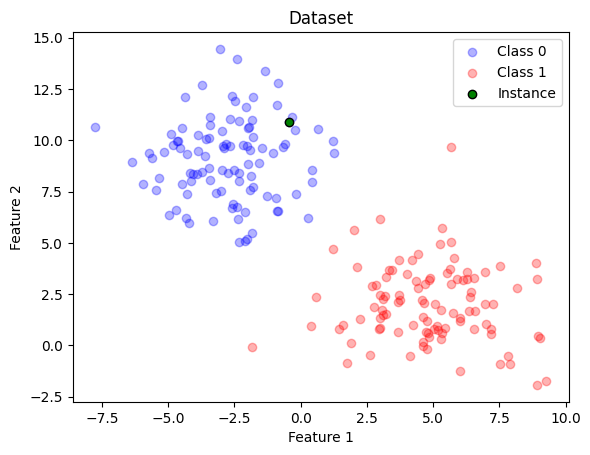

In [15]:
#| label: fig-dummy-dataset
#| fig-cap: "Dummy dataset"
#| layout-ncol: 1
#| code-fold: true

instance_to_explain = np.where(X==X_test[0])[0][0]

assert (X[instance_to_explain]==X_test[0]).all()

def plot_dataset_with_instance(X, y, highlight_row=None, title="Dataset"):
    # Assuming you have two classes 0 and 1
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    # Create a scatter plot for each class
    plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0', alpha=0.3)
    plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class 1', alpha=0.3)
    
    if highlight_row is not None:
        plt.scatter(X[highlight_row, 0], X[highlight_row, 1], c='green', label='Instance', alpha=1, marker='o', edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    
    # Add a legend to the plot
    plt.legend()
    
    plt.show()

# Pass in the index of the row you want to highlight
plot_dataset_with_instance(X, y, highlight_row=instance_to_explain)

We want to explain the geen instance. Let's see each case :)

## Exact SHAP {#sec-exact-shap}

[According to docs](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Exact.html#Exact-explainer), the Exact explainer can be utilized to compute Shapley values for any given model. Nevertheless, as it exhaustively navigates the masking pattern space, its complexity for Shapley values stands at $\mathcal{O} (2^M)$.

### Shapley Values

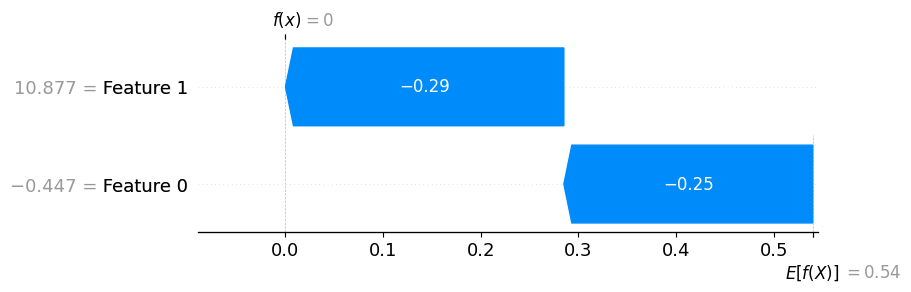

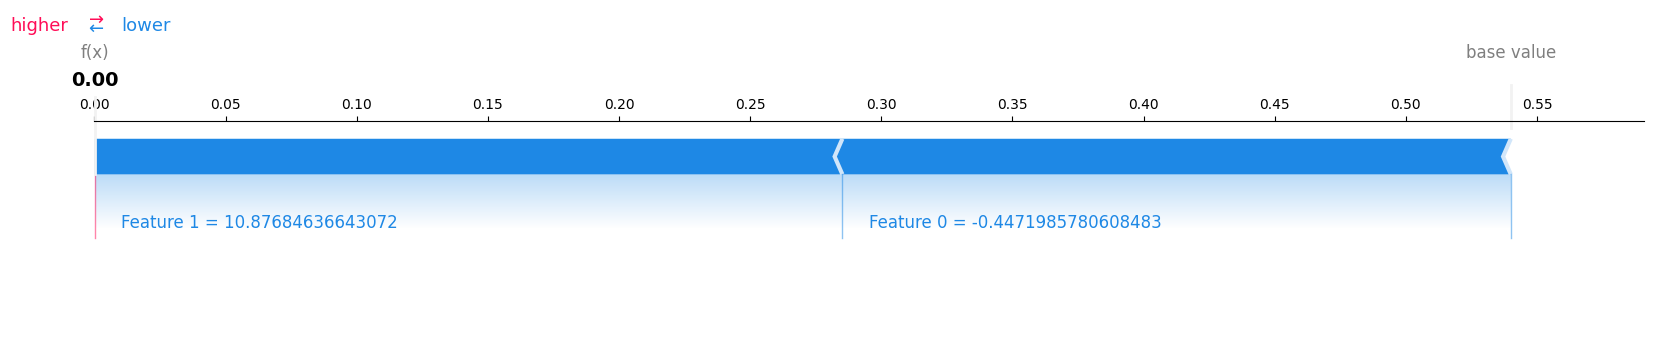

In [16]:
#| label: shap-waterfall-force-dummy
#| fig-cap: Waterfall and Force Plot
#| fig-subcap: 
#|   - "SHAP waterfall plot"
#|   - "SHAP force plot for a single instance"
#| fig-alt:
#|   - "Waterfall Plot"
#|   - "Force Plot"
#| layout-ncol: 2

import shap
masker = shap.maskers.Independent(X_train)
explainer = shap.explainers.Exact(model=clf.predict_proba, masker=masker, feature_names=["Feature 0", "Feature 1"])
shap_values = explainer(X_test[:1])

# get just the explanations for the positive class
shap_values = shap_values[...,1]


shap.plots.waterfall(shap_values[0])
shap.plots.force(shap_values[0], matplotlib=True)

Both graphs shows the same information. Let's break it down:

- We have the original Features: {"Feature 0": -0.44719, "Feature 1": 10.8768}
- The Expected Value $E[f(z) | z_S]$, or $\phi_0$: 0.54
- The Shapley Values for each feature, $\phi_i$: {"ShapleyFeature0": -0.29, "ShapleyFeature1": -0.25}, which were obtained from @eq-shapley-theorem

If we apply these values to {#eq-additive-effect}, we do have the following:

\begin{align*}
f(x) \approx g(z') = \phi_0 + \sum_{i=1}^{M} \phi_i z'_i \\
f(x) \approx \phi_0 + \sum_{i=1}^{M} \phi_i z'_i \\
f(x) \approx 0.54 + -0.29*1 -0.25*1 \\
f(x) \approx 0
\end{align*}

Remember that $z'_i \in \{0,1\}^M$, so it is a binary vector and it is $1$ when the feature is present. Let's see if this matches the real result:

In [17]:
prob_class_1 = clf.predict_proba(X_test[:1])[:,1]
np.allclose(prob_class_1,(shap_values.base_values[0] + np.sum(shap_values.values)))

True

Cool! :)

### Owen Values

According to [@OwenValues], the **Owen Values** are a generalization of **Shapley Values** that take into account a priori coalition structure. Strictly speaking, while Shapley Values assumes independence of players (in our case, feature independence), Owen Values takes into consideration a coalition structure (i.e. "players who agreed to play together for their mutual benefit"). In machine learning domain, this coalition can be understood as some way of grouping features together, which can thus be achieved through some form of unsurpervised clustering.

In practice, instead of having a complexity of $\mathcal{O}(2^M)$ (the Shapley Values case), we do have a complexity of $\mathcal{O}(M^2)$ on a balanced clustering tree of $M$ features.

[The documentation](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Exact.html#Tabular-data-with-partition-(Owen-value)-masking) states that applying such a structure results in a structured game (i.e., a game with specific rules about valid input feature coalitions). When this structure represents a nested set of feature groupings, we obtain Owen values, which are a recursive application of Shapley values to the group. **In SHAP, we take this partitioning to the extreme by constructing a binary hierarchical clustering tree to represent the data's structure**. While there are many ways to choose this structure, it is often beneficial to build it from the redundancy of information between the input features and the output label, particularly for tabular data.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


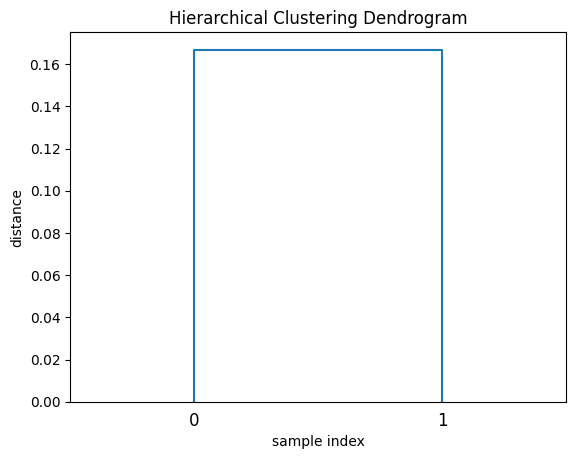

In [18]:
#| label: owen-values-dendogram
#| fig-cap: Clustering Tree Dendogram for Dummy dataset
#| fig-alt:
#|   - "Clustering Dendogram"
#| layout-ncol: 1

from scipy.cluster.hierarchy import dendrogram

# build a clustering of the features based on shared information about y
clustering = shap.utils.hclust(X_train, y_train, metric="xgboost_distances_r2")
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(clustering)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

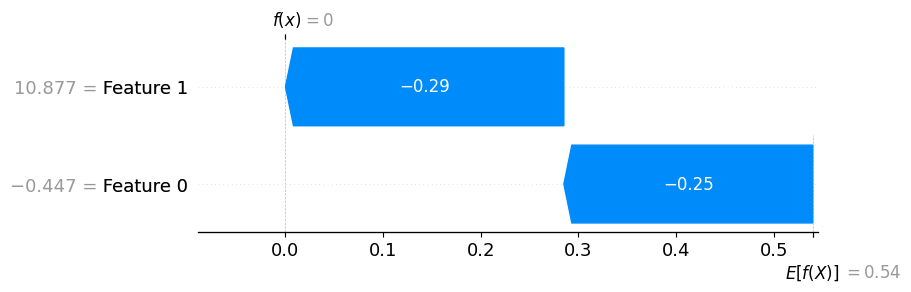

In [19]:
masker = shap.maskers.Partition(X_train, clustering=clustering)
explainer = shap.explainers.Exact(model=clf.predict_proba, masker=masker, feature_names=["Feature 0", "Feature 1"])
shap_values = explainer(X_test[:1])

# get just the explanations for the positive class
shap_values = shap_values[...,1]


shap.plots.waterfall(shap_values[0])

:::{.callout-important}

As stated, the Owen value is an extension of the Shapley value, adapted for scenarios where the coalitions' composition matters in the game. **If the game doesn't come with an inherent coalition structure, then the Owen value simplifies to the standard Shapley value.** (which just happenend as the cluster didnt have any structure since we're dealing with two features)

:::

## Approximate SHAP

Precisely calculating SHAP values can be complex. Yet, by integrating understandings from existing additive feature attribution methods, it's possible to approximate them.

### Model Agnostic
The algorithms shown in this section outlines two examples of way to approximate Shapley Values for _any_ blackbox model

#### Kernel SHAP

In the context of Linear LIME, a linear model is employed to approximate the original function $f$, localized within the simplified binary input space. Upon an initial examination, you might think that @eq-lime diverges significantly from the traditional formulation of Shapley values, as defined in @eq-shapley-theorem. Despite this apparent disparity, it worth mentioning that as Linear LIME is as an additive feature attribution method, the Shapley values remain the unique solution to @eq-lime that complies with @def-property, @def-missingness, and @def-consistency. 

A valid question then is whether the solution to @eq-lime accurately retrieves these Shapley values. This retrieval is **contingent upon specific selections for the loss function $L$, the weighting kernel $\pi_{x'}$, and the regularization term $\Omega$** (See @thm-shapley-kernel). In the original study[@LIMEPaper], these parameters are determined heuristically and under this circumstance @eq-lime either violates @def-property and/or @def-consistency.

::: {#thm-shapley-kernel}

Under @def-additive, the specific forms of $\pi_{x'}$ , $L$, and $\Omega$ that make solutions of @eq-lime consistent with @def-property, @def-missingness,@def-consistency are:

\begin{align*}
\Omega(g) = 0 \\
\pi_{x'}(z') = \frac{(M-1)}{(M \text{ choose }|z'|)|z'|(M-|z'|)} \\
L(f,g,\pi_{x'}) = \sum_{z' \in Z} [f(h_x(z')) - g(z')]^2 \pi_{x'}(z')
\end{align*}

Where $|z'|$ is the number of non-zero elements in $z'$

:::


:::{.callout-important}

I thought if it would worth to place @thm-shapley-kernel here, but the proof is 2 pages long. If you want to check, please refer to this [link](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html#:~:text=SHAP%20assigns%20each%20feature%20an%20importance%20value%20for,this%20class%20with%20a%20set%20of%20desirable%20properties.) and click on `Supplemental` tab :) 

:::

:::{.callout-note}

It's essential to highlight that the equation $\pi_{x'}(z') = \infty$ applies when $|z'| \in \{0,M\}$, which results in the conditions $\phi_0 = f_x(\emptyset)$ and $f(x) = \sum_{i=0}^M \phi_i$. When practically implementing these equations, the challenges linked to infinite weights can be avoided in the optimization phase by methodically removing two variables in line with these constraints. This analytical approach maintains the integrity of the mathematical formulation while also addressing computational needs.


:::

Given that $g(z')$ in @thm-shapley-kernel is assumed to follow a linear form, and $L$ represents a squared loss, the equation @eq-lime can be solved using linear regression techniques. This means that Shapley values, derived from game theory principles, can be computed through weighted linear regression methods. An observation made by the authors is that estimating all SHAP values collectively through regression offers better sample efficiency compared to the direct application of the classical Shapley equation.

The intuitive link between linear regression and Shapley values becomes clear when recognizing that @eq-shapley-theorem is a difference of means. Since the arithmetic mean is also the optimal least squares point estimate for a set of data points, it becomes natural to look for a weighting kernel that enables linear least squares regression to reproduce the Shapley values. This investigation leads to the identification of a kernel that significantly differs from those previously selected heuristically in the context of LIME.

:::{.callout-tip}

I'll use the **identity** link for educational purposes. Analyzing the [docs](https://github.com/shap/shap/blob/master/shap/explainers/_kernel.py#L71) we can see it is an only "unit" point of view:


> A generalized linear model link to connect the feature importance values to the model
    output. Since the feature importance values, $\phi$, sum up to the model output, it often makes
    sense to connect them to the output with a link function where link(output) = $\sum_{i} \phi_i$.
    If the model output is a probability then the LogitLink link function makes the feature
    importance values have log-odds units.

:::

Using 140 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

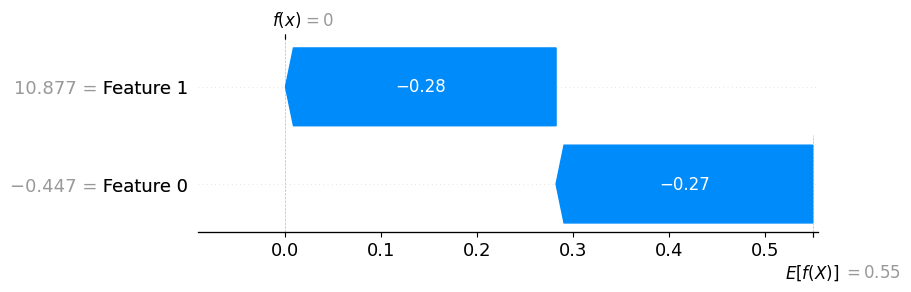

In [26]:
explainer = shap.KernelExplainer(model=clf.predict_proba, 
                                 data=X_train, 
                                 feature_names=["Feature 0", "Feature 1"], link="identity")
shap_values = explainer(X_test[:1])

# get just the explanations for the positive class
shap_values = shap_values[...,1]


shap.plots.waterfall(shap_values[0])

:::{.callout-tip}

As the logging results pointed out and if we check the [docs](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20Kernel%20SHAP.html#Using-KernelExplainer): 


> KernelExplainer does a sampling approximation for large values of $M$, but for small values it  enumerates the entire $2^M$ sample space


:::

We can see that the values differs a bit from @sec-exact-shap since it is an approximation :)

#### Shapley sampling values

This technique employ a sampling approximation for a permutation-based version of the classic Shapley value equations, as found in @eq-shapley-theorem.


### Model Specific 

#### Max SHAP

TODO

#### Deep SHAP

TODO

#### TreeSHAP

TODO

### Getting real

Let's use the same dummy dataset that I used for Anchors example. **There are a few differences, however**:
- We will be creating a SimpleNeuralNetwork classifier and we will use it as our blackbox model
- We will be using StandardScaler to scale our features

In [27]:
#| code-fold: true

import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def predict(self, x, threshold=0.5):
        self.eval()
        # Ensure x is a 2D tensor: add an extra dimension if x is a 1D tensor
        if len(x.shape) == 1:
            x = x.unsqueeze(0) 
        label_probability = self(x)
        y = (label_probability > threshold).float()
        return y

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


# Generate a 2D dataset with two classes
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=2.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

std_features = StandardScaler()
std_features.fit(X_train)

StandardScaler()

And then train the network

In [ ]:
#| code-fold: true

import torch.optim as optim

# Define network parameters
input_size = X_train.shape[1]
hidden_size = 5

# Instantiate the network, loss function, and optimizer
net = SimpleNet(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)
epochs = 2000
for epoch in tqdm(range(epochs), desc="Training Neural Net"):
    net.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = net(torch.from_numpy(std_features.transform(X_train).astype(np.float32)))
    # Compute Loss
    loss = criterion(y_pred, torch.from_numpy(y_train.reshape(-1, 1).astype(np.float32)))

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # print progress
    if (epoch+1) % 500 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item()}')

Training Neural Net:   0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 500, loss = 0.009603435173630714
epoch: 1000, loss = 0.005159247666597366
epoch: 1500, loss = 0.0036031161434948444
epoch: 2000, loss = 0.0027885879389941692


In [ ]:
from sklearn.metrics import accuracy_score
predictions = net.predict(torch.from_numpy(std_features.transform(X_test).astype(np.float32))).numpy().reshape(-1)
accuracy_score(y_test, predictions)

1.0

It was pretty easy to get a perfect model, which was expected. 

Then, now I want to explain a single instance from `test` set. Let's take the first element :)

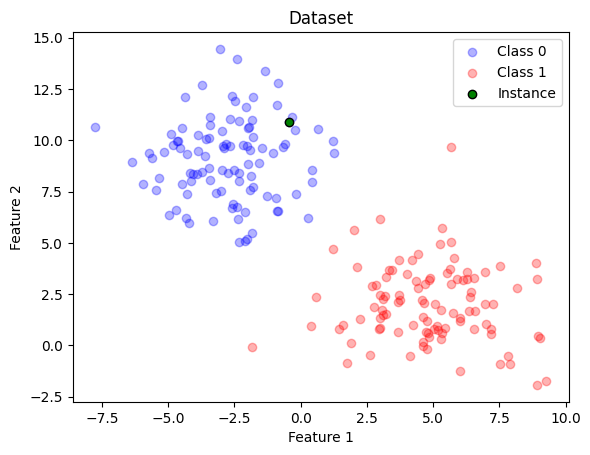

In [ ]:
#| code-fold: true

instance_to_explain = np.where(X==X_test[0])[0][0]

assert (X[instance_to_explain]==X_test[0]).all()

def plot_dataset_with_instance(X, y, highlight_row=None, counterfactual_instance_list=None, title="Dataset"):
    # Assuming you have two classes 0 and 1
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    # Create a scatter plot for each class
    plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0', alpha=0.3)
    plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class 1', alpha=0.3)
    
    if highlight_row is not None:
        plt.scatter(X[highlight_row, 0], X[highlight_row, 1], c='green', label='Instance', alpha=1, marker='o', edgecolors='k')
    
    if counterfactual_instance_list is not None and isinstance(counterfactual_instance_list, list):
        for counterfactual_instance in counterfactual_instance_list:
            plt.scatter(counterfactual_instance[0], counterfactual_instance[1], 
                        c='cyan', label='Counterfactual Instance', alpha=1, marker='o', edgecolors='k')
        
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    
    # Add a legend to the plot
    plt.legend()
    
    plt.show()

# Pass in the index of the row you want to highlight
plot_dataset_with_instance(X, y, highlight_row=instance_to_explain)

Therefore, we want to find the _set of candidates_ that makes the **green** instance becomes **red**. For that, then let's use the `learn_counterfactuals` defined earlier with the following consierations:

- $x=$ the same instance that we are trying to get the counterfactuals, transformed from **std_features**
- $\text{yloss}$ is the hinge_loss that we defined earlier
- $\text{distance\_function}$ is the $\text{distance\_continuous}$ that was defined earlier
- $\text{lambda\_1}=\lambda_1=0.5$
- $\text{lambda\_2}=\lambda_2=2.0$
- $\text{model\_predict}$ will be our `net` model which we just trained
- $k=3$, so we are trying to learn a three counterfactual

In [ ]:
instance_to_explain = X_test[0]
reference_instance = np.where(X==instance_to_explain)[0][0]
x = torch.from_numpy(std_features.transform(instance_to_explain.reshape(1,-1)).astype(np.float32))
lambda_1 = 0.5
lambda_2 = 2.0
number_of_counterfactuals = 3

# Give me a ~~real~~ use case :)

For using a real library, let's rely on [DiCE](https://github.com/interpretml/DiCE/tree/main) project

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import dice_ml
import pandas as pd
import json


instance_to_explain = pd.DataFrame(X_test[[0]], columns=["Feature 1", "Feature 2"])
x_train_pd = pd.DataFrame(X_train, columns=["Feature 1", "Feature 2"])
y_labels_pd = pd.Series(y_train, name="label")
train_pd = pd.concat([x_train_pd, y_labels_pd], axis=1)
dice_data = dice_ml.Data(dataframe=train_pd, outcome_name='label', continuous_features=["Feature 1", "Feature 2"])
dice_model = dice_ml.Model(model=net, backend="PYT")
exp = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model, method="gradient")

In [ ]:
e1 = exp.generate_counterfactuals(instance_to_explain, 
                                  total_CFs=number_of_counterfactuals,
                                  desired_class="opposite",
                                  proximity_weight=lambda_1,
                                  diversity_weight=lambda_2,
                                )

100%|██████████| 1/1 [00:55<00:00, 55.65s/it]

Diverse Counterfactuals found! total time taken: 00 min 04 sec


In [ ]:
e1.visualize_as_dataframe(show_only_changes=False)

Query instance (original outcome : 0)


,Feature 1,Feature 2,label
0,-0.447199,10.876846,0.0



Diverse Counterfactual set (new outcome: 1.0)


,Feature 1,Feature 2,label
0,-0.000100,0.188946,1
1,0.389938,0.612188,1
2,0.634860,1.000000,1


In [ ]:
#| echo: false

counterfactuals_result = np.array(json.loads(e1.to_json())['cfs_list'])[0][:,:2]
counterfactual_changes = []
for i in counterfactuals_result:
    counterfactual_changes.append(i)

Let's plot the results comparing my implementation and DiCE one

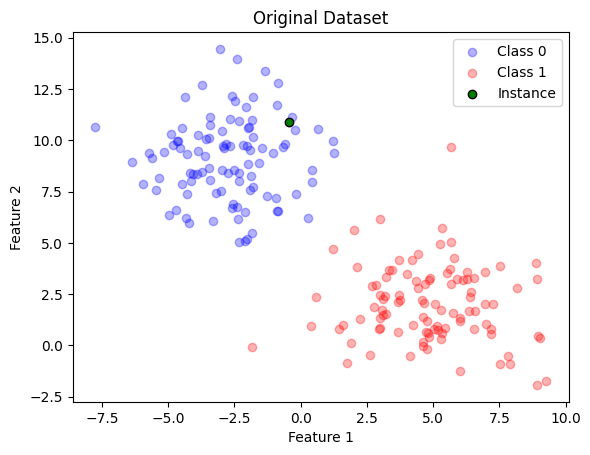

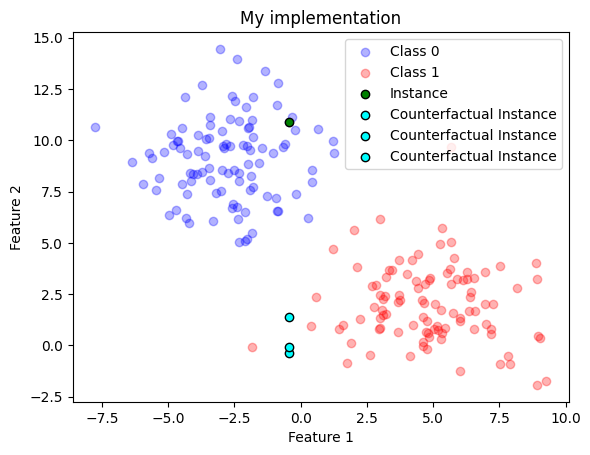

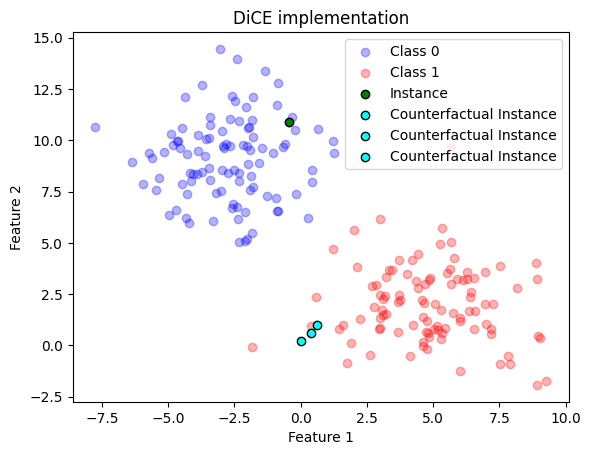

In [ ]:
#| label: fig-counterfactual-dice
#| fig-cap: 
#| fig-subcap: 
#|   - "Initial data"
#|   - "Counterfactuals from my implementation"
#|   - "Counterfactuals through dice"
#| fig-alt:
#|   - "Initial data"
#|   - "My implementation"
#|   - "After DiCE"
#| layout-ncol: 3
#| echo: false

plot_dataset_with_instance(X, y, highlight_row=reference_instance, title="Original Dataset")
plt.show()
plot_dataset_with_instance(X, y, highlight_row=reference_instance, counterfactual_instance_list=c_sparse, title="My implementation")
plt.show()
plot_dataset_with_instance(X, y, highlight_row=reference_instance, counterfactual_instance_list=counterfactual_changes, title="DiCE implementation")
plt.show()

::: {.callout-note}

There can be many reasons for the DiCE results being different than the ones that I achieved, but they look close :) I suspect that could be tiny details in the post processing part that I might have missed

:::

## A real case indeed

Let's use the same dataset example that I've used in [Anchors Example](2023-06-24-annotated-anchors.html#a-real-example).

However, one caveat here though is that **we require binary classes only**. For that, I will merge `N,NE` into a single group, `N` and `S,SE` into another group, `S` and I'll drop `CO`

In [ ]:
#| code-fold: true

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/temp-alt-2020.csv", index_col=0).reset_index(drop=True)
FEATURE_COLUMNS = ["altitude", "temperature"]
LABEL_COLUMN = "region"
new_label_dict = {'N': 'North', 'NE': 'North', 'S': 'South', 'SE': 'South', 'CO': 'CO'}
df[LABEL_COLUMN] = df[LABEL_COLUMN].map(new_label_dict)
df = df[df[LABEL_COLUMN] != "CO"]
df = df[FEATURE_COLUMNS+[LABEL_COLUMN]]

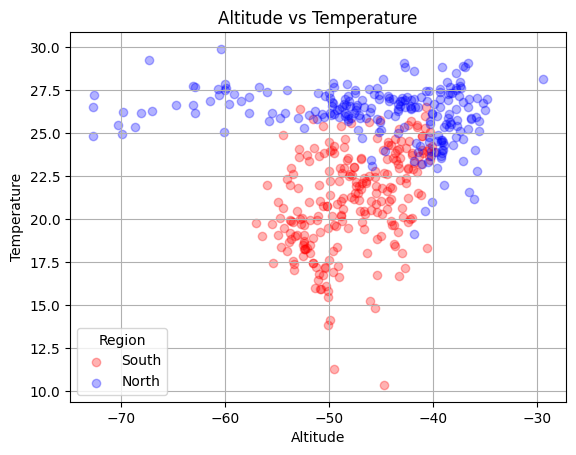

In [ ]:
#| label: fig-geography-dataset
#| fig-cap: "Brazilian regions with Altitude and Temperature"
#| layout-ncol: 1
#| echo: false

colors={"North": "blue", "South": "red"}
def plot_data(df, separate_instances=None):
    for region in df["region"].unique():
        plt.scatter(df[df["region"]==region]["altitude"],
                    df[df["region"]==region]["temperature"],
                    color=colors[region],
                    label=region,
                    alpha=0.3
                    )
    if separate_instances is not None and isinstance(separate_instances, pd.DataFrame):
        for idx, row in separate_instances.iterrows():
            plt.scatter(row["altitude"], 
                        row["temperature"], 
                        color='cyan', 
                        label='Counterfactual Instance', 
                        alpha=1, 
                        marker='o', 
                        edgecolors='k'
                        )
            
    plt.xlabel('Altitude')
    plt.ylabel('Temperature')
    plt.title('Altitude vs Temperature')
    plt.legend(title='Region')
    plt.grid(True)
    plt.show()

plot_data(df)

In [ ]:
#| code-fold: true

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


encoder = LabelEncoder()
std_features = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(df[FEATURE_COLUMNS], df[LABEL_COLUMN], test_size=0.2, random_state=42)

encoded_labels_train = encoder.fit_transform(y_train)
encoded_labels_test = encoder.transform(y_test)
std_features.fit(X_train)

StandardScaler()

In [ ]:
#| echo: false

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def predict(self, x, threshold=0.5):
        self.eval()
        # Ensure x is a 2D tensor: add an extra dimension if x is a 1D tensor
        if len(x.shape) == 1:
            x = x.unsqueeze(0) 
        label_probability = self(x)
        y = (label_probability > threshold).float()
        return y

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [ ]:
#| code-fold: true

# Define network parameters
input_size = X_train.shape[1]
hidden_size = 5

# Instantiate the network, loss function, and optimizer
net = SimpleNet(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.01)
epochs = 20000
for epoch in tqdm(range(epochs), desc="Training Neural Net"):
    net.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = net(torch.from_numpy(std_features.transform(X_train.values).astype(np.float32)))
    # Compute Loss
    loss = criterion(y_pred, torch.from_numpy(encoded_labels_train.reshape(-1, 1).astype(np.float32)))

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # print progress
    if (epoch+1) % 4000 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item()}')

Training Neural Net:   0%|          | 0/20000 [00:00<?, ?it/s]

epoch: 4000, loss = 0.193984717130661
epoch: 8000, loss = 0.17410410940647125
epoch: 12000, loss = 0.1702796220779419
epoch: 16000, loss = 0.16826167702674866
epoch: 20000, loss = 0.16802458465099335


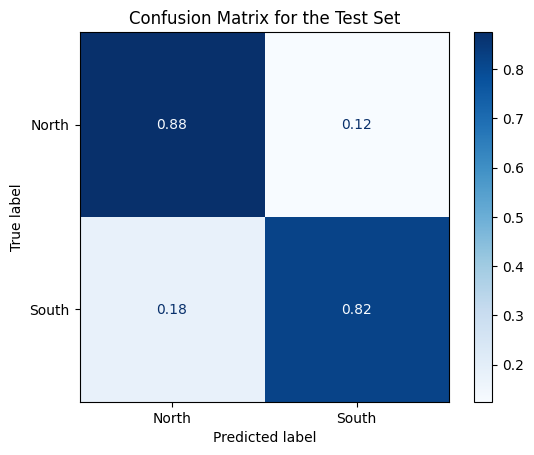

In [ ]:
#| label: fig-confusion-matrix-real-dataset
#| fig-cap: "Test Confusion Matrix for Geography Example"
#| layout-ncol: 1
#| code-fold: true

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

net.eval()
predicted_classes = net.predict(torch.from_numpy(std_features.transform(X_test.values).astype(np.float32)))
cm = confusion_matrix(encoded_labels_test, predicted_classes.detach().numpy(), normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for the Test Set")
plt.show()

Not so bad :)

Let's see how a counterfactual would be. In the example case I will chose a North class prediction and I want to find counterfactuals that would change it to South class

In [ ]:
dice_data = dice_ml.Data(dataframe=df[FEATURE_COLUMNS+[LABEL_COLUMN]],
                          outcome_name=LABEL_COLUMN, 
                          continuous_features=FEATURE_COLUMNS)
dice_model = dice_ml.Model(model=net, backend="PYT")
exp = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model, method="gradient")

In [ ]:
north_south_sample_idx = y_test[y_test.isin(['North'])].head(1).index.tolist()

In [ ]:
e1 = exp.generate_counterfactuals(X_test.loc[north_south_sample_idx], 
                                  total_CFs=1,
                                  desired_class="opposite",
                                  proximity_weight=lambda_1,
                                  diversity_weight=lambda_2,
                                )

100%|██████████| 1/1 [00:12<00:00, 12.96s/it]

Diverse Counterfactuals found! total time taken: 00 min 12 sec


In [ ]:
e1.visualize_as_dataframe()

Query instance (original outcome : 0)


,altitude,temperature,region
0,-38.931068,21.980341,0.0



Diverse Counterfactual set (new outcome: 1.0)


,altitude,temperature,region
0,-2.989883e-09,0.475309,1


Actually there is a little caveat here. The authors are implictly using `StandardScaling` for counterfactual training. So we need to revert it back

In [ ]:
#| code-fold: true

import json

cfs_list = np.array(json.loads(e1.to_json())['cfs_list'][0])
cfs_list = cfs_list[:,:-1]
counterfactuals_df = pd.DataFrame(std_features.inverse_transform(cfs_list), columns=["altitude", "temperature"])

As we compare to @fig-geography-dataset, it is possible to validate that the results actually makes sense :)

::: {.callout-note}

It is interesting to notice that the learned counterfactuals seem to be in the decision boundary _frontier_, which is an expected behavior!

:::

# Conclusion


This concludes our journey to explain Diverse Counterfactuals Explanation algorithm, which is one of many model-specific explanation :)